In [1]:
import os
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import logging
import time

In [2]:
from datetime import datetime
from PyQt5.QtWidgets import QApplication, QFileDialog
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import firwin, filtfilt
from scipy.io import loadmat

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LeakyReLU

In [4]:
def select_folder():
    app = QApplication([])  
    folder_path = QFileDialog.getExistingDirectory(None, "Select a Folder")
    return folder_path

In [5]:
import time
import logging
import os
import segyio
import numpy as np
import pandas as pd
from datetime import datetime

def seismic_data():
    logging.basicConfig(level=logging.INFO)
    
    folder_path = select_folder()
    if not folder_path:
        print("No folder selected. Exiting.")
        return None
    
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if not files:
        print("No files found in the selected folder. Exiting.")
        return None

    n_files = len(files)
    
    i_line = 189
    x_line = 193
    dp_x = 181
    dp_y = 185
    
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d %H:%M:%S")
    
    start_time = time.time()  # Start time

    f = {}
    for i in range(n_files):
        file_name = files[i].split("/")[-1]
        f[i] = segyio.open(files[i])
        logging.info("Input Attributes: " + str(file_name))
        sgs = f[0].header[0][71]
        logging.info("Iline Range: " + str(min(f[i].ilines)) + "-" + str(max(f[i].ilines)) + "(byte: {})".format(i_line))
        logging.info("Xline Range: " + str(min(f[i].xlines)) + "-" + str(max(f[i].xlines)) + "(byte: {})".format(x_line))
        logging.info("Sample Range: " + str(min(f[i].samples)) + "-" + str(max(f[i].samples)))
        
        cdpx = [f[i].header[0][dp_x], f[i].header[-1][dp_x], f[i].header[-(len(f[i].xlines))][dp_x],
                f[i].header[len(f[i].xlines) - 1][dp_x]]
        cdpy = [f[i].header[0][dp_y], f[i].header[-1][dp_y], f[i].header[-(len(f[i].xlines))][dp_y],
                f[i].header[len(f[i].xlines) - 1][dp_y]]
        iline_cood = [f[i].header[0][i_line], f[i].header[-1][i_line], f[i].header[-(len(f[i].xlines))][i_line],
                      f[i].header[len(f[i].xlines) - 1][i_line]]
        xline_cood = [f[i].header[0][x_line], f[i].header[-1][x_line], f[i].header[-(len(f[i].xlines))][x_line],
                      f[i].header[len(f[i].xlines) - 1][x_line]]
        
        len1 = (((cdpx[0] - cdpx[3]) ** 2) + ((cdpy[0] - cdpy[3]) ** 2)) ** (1 / 2)
        len2 = (((cdpx[0] - cdpx[2]) ** 2) + ((cdpy[0] - cdpy[2]) ** 2)) ** (1 / 2)
        
        deg_1 = np.angle(complex((cdpx[3] - cdpx[0]), (cdpy[3] - cdpy[0])), deg=True)
        if (deg_1 < 0):
            fin_deg = 270 + deg_1
        elif (deg_1 >= 0) and (deg_1 <= 90):
            fin_deg = 90 - deg_1
        else:
            fin_deg = 450 - deg_1
        logging.info("SGS: " + str(sgs))
        logging.info("X Range: " + str(min(cdpx)) + "-" + str(max(cdpx)))
        logging.info("Y Range: " + str(min(cdpy)) + "-" + str(max(cdpy)))
        
    sgs = f[0].header[0][71]
    iline = [4700, 5560]
    xline = [1100, 1400]
    samples = [3048, 3652]

    skip = 0  # inlines and xlines have been skipped to optimize available infrastructure
    w = skip + 1  # To be added in the widget, either skip= 0 or 1

    min_depth = min(f[0].samples)
    max_depth = max(f[0].samples)
    depth_interval = f[0].samples[1] - f[0].samples[0]
    min_xlines = min(f[0].xlines)
    max_xlines = max(f[0].xlines)
    min_ilines = min(f[0].ilines)
    max_ilines = max(f[0].ilines)
    samples_l = int(samples[0])
    samples_u = int(samples[1])
    depth = int(((samples_u - samples_l) / depth_interval) + 1)
    a1 = int((samples[0] - min(f[0].samples)) / depth_interval)
    b1 = int((samples[1] - min(f[0].samples)) / depth_interval) + 1

    ilines = round(((iline[1] - iline[0]) + 1) / w)
    xlines = round(((xline[1] - xline[0]) + 1) / w)

    plane = []
    for il in range(iline[0], iline[1] + 1, w):
        for xl in range(xline[0], xline[1] + 1, w):
            ie = (il - min_ilines) * len(f[0].xlines) + (xl - min_xlines)
            plane.append(ie)

    final_values2 = np.empty([5 + n_files, xlines * ilines * depth], dtype=np.float32)
    x = [f[0].header[i][i_line] for i in plane]
    x1 = [np.repeat(i, depth) for i in x]
    final_values2[0] = np.reshape(x1, (xlines * ilines * depth,))

    y = [f[0].header[i][x_line] for i in plane]
    y1 = [np.repeat(i, depth) for i in y]
    final_values2[1] = np.reshape(y1, (xlines * ilines * depth,))
    del y1
    del y

    final_values2[4] = np.tile(f[0].samples[a1:b1], xlines * ilines)

    cdpx = [f[0].header[i][dp_x] for i in plane]
    cdpx1 = [np.repeat(i, depth) for i in cdpx]
    final_values2[2] = np.reshape(cdpx1, (xlines * ilines * depth,))
    del cdpx1
    del cdpx

    cdpy = [f[0].header[i][dp_y] for i in plane]
    cdpy1 = [np.repeat(i, depth) for i in cdpy]
    final_values2[3] = np.reshape(cdpy1, (xlines * ilines * depth,))
    del cdpy1
    del cdpy

    v = {}
    for attr in range(n_files):
        v[attr] = [f[attr].trace[i][a1:b1] for i in plane]
        v[attr] = np.reshape(v[attr], (xlines * ilines * depth,))
        final_values2[attr + 5] = v[attr]
    del v

    final_values2 = final_values2.T

    array_index = np.array([i for i in range(len(final_values2))]).reshape(final_values2.shape[0], 1)
    final_values2 = np.concatenate((array_index, final_values2), axis=1)

    del array_index

    df_s = pd.DataFrame(final_values2).rename(columns={0: 'index', 1: 'inline', 2: 'xline', 3: 'X', 4: 'Y', 5: 'TWT', 6: 'RMS', 7:'Env', 8:'Ins. Freq.', 9:'Ins. Ph.', 10:'Ref. Inten.', 11:'Sweetness'})
    df_s["Y"] = df_s.Y / 100
    
    end_time = time.time()  # End time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution Time: {execution_time:.2f} seconds")

    return df_s

if __name__ == "__main__":
    df_s = seismic_data()
    if df_s is not None:
        display(df_s)


INFO:root:Input Attributes: Oshie_seis\1RMS_ZOI_IN4700-5560_XL_1100-1400_Z_3050-3650MS.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\Envelop_attribute.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\Instantaneous_Frequency.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xline Range: 1100-1400(byte: 193)
INFO:root:Sample Range: 3048.0-3652.0
INFO:root:SGS: -100
INFO:root:X Range: 44447488-46601713
INFO:root:Y Range: 11616539-12379604
INFO:root:Input Attributes: Oshie_seis\Instantaneous_Phase.sgy
INFO:root:Iline Range: 4700-5560(byte: 189)
INFO:root:Xlin

Execution Time: 50.68 seconds


,index,inline,xline,X,Y,TWT,RMS,Env,Ins. Freq.,Ins. Ph.,Ref. Inten.,Sweetness
0,0.0,4700.0,1100.0,44452072.0,116165.39,3048.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,4700.0,1100.0,44452072.0,116165.39,3052.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.0,4700.0,1100.0,44452072.0,116165.39,3056.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.0,4700.0,1100.0,44452072.0,116165.39,3060.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4.0,4700.0,1100.0,44452072.0,116165.39,3064.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
39392467,39392467.0,5560.0,1400.0,46597132.0,123796.04,3636.0,631.894226,974.667053,30.053131,58.038490,2.063758,152.183578
39392468,39392468.0,5560.0,1400.0,46597132.0,123796.04,3640.0,583.211975,696.498901,34.473694,111.739098,1.834452,83.591652
39392469,39392469.0,5560.0,1400.0,46597132.0,123796.04,3644.0,550.604126,546.167175,38.620373,160.848587,1.662472,85.813293
39392470,39392470.0,5560.0,1400.0,46597132.0,123796.04,3648.0,493.974457,427.436188,43.225388,-127.122993,1.433165,134.797180


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df=df_s[df_s!=0].dropna()

well logs

In [8]:
import os
import pandas as pd
import lasio

def well_data(folder_path):
    df_well_og = pd.DataFrame()
    files = os.listdir(folder_path)
#     display(files)

    df_1 = pd.DataFrame()
    for file_name in files:
        las = lasio.read(os.path.join(folder_path, file_name))
        las = las.df()
        las = las.reset_index()
        well_name = file_name.split('.')[0]  
        las['WELL'] = well_name 
        df_1 = pd.concat([df_1, las])
       
    df_1=df_1[['DEPT','DT', 'GR', 'ILD', 'SN', 'NPHI', 'RHOB', 'SP', 'BS', 'CALI', 'PHIT', 'PIGE', 'RHGA','SUWI','VCL','EFAC_MERGED','WELL']]
    df_1=df_1.rename(columns={"DEPT":'MD'})
    return df_1


if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            df_well_og = well_data(folder_path)
            display(df_well_og)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")


INFO:lasio.reader:Opening C:/indorama_gd_12_01/Oshie_logs\Oshi-01 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/indorama_gd_12_01/Oshie_logs\Oshi-03 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/indorama_gd_12_01/Oshie_logs\Oshi-07 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/indorama_gd_12_01/Oshie_logs\Oshi-10 as ascii and treating errors with "replace"
INFO:lasio.las:The read substitutions ['run-on(-)']have been removed as this file appears to contain hyphens.
INFO:lasio.reader:Opening C:/indorama_gd_12_01/Oshie_logs\Oshi-13 as ascii and treating errors with "replace"
INFO:lasio

,MD,DT,GR,ILD,SN,NPHI,RHOB,SP,BS,CALI,PHIT,PIGE,RHGA,SUWI,VCL,EFAC_MERGED,WELL
0,1300.12486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01
1,1300.27726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01
2,1300.42966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01
3,1300.58206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01
4,1300.73446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20450,4299.35640,86.294907,NaN,NaN,NaN,NaN,NaN,94.058601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04
20451,4299.50880,86.307297,NaN,NaN,NaN,NaN,NaN,94.338097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04
20452,4299.66120,86.307297,NaN,NaN,NaN,NaN,NaN,94.394997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04
20453,4299.81360,86.326904,NaN,NaN,NaN,NaN,NaN,94.394997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04


tdr data

In [9]:
import os
import pandas as pd

def tdr_data(folder_path, skip_rows):
    df_tdr = pd.DataFrame()

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.txt'):
            with open(file_path, 'r') as file:
                dataframe1 = pd.read_csv(file, skiprows=skip_rows, header=None, sep="\s+|\t")
                dataframe1['Well name'] = filename.split("_")[0]
                df_tdr = pd.concat([df_tdr, dataframe1], ignore_index=True)
        
    df_tdr = df_tdr.rename(columns={0: 'MD', 1: "TWT"}) 
    df_tdr = df_tdr[df_tdr != -999.2500]
    df_tdr = df_tdr.dropna()
    df_tdr = df_tdr.reset_index(drop=True)
    
    return df_tdr

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 1 row")
            skip_rows = int(input("Enter the number of rows to skip: "))
            
            df_tdr = tdr_data(folder_path, skip_rows)
            display(df_tdr)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 1 row
Enter the number of rows to skip: 1


,MD,TWT,Well name
0,0.00,-27.56,Oshi-01.txt
1,0.15,-27.41,Oshi-01.txt
2,0.30,-27.26,Oshi-01.txt
3,0.46,-27.11,Oshi-01.txt
4,0.61,-26.96,Oshi-01.txt
...,...,...,...
81512,4382.41,3285.14,Ubie-04.txt
81513,4382.57,3285.22,Ubie-04.txt
81514,4382.72,3285.30,Ubie-04.txt
81515,4382.87,3285.38,Ubie-04.txt


In [10]:
# Remove .txt in-place
df_tdr['Well name'] = df_tdr['Well name'].str.replace(r'\.txt$', '', regex=True)

# Tuple-like string
tuple_str = "(" + ",".join(df_tdr['Well name'].tolist()) + ")"

deviation data

In [11]:
def dev_data(folder_path,skip_rows):
    df_dev = pd.DataFrame()
    # df = pd.concat([df, pd.DataFrame([{'a':1, 'b':2}])], ignore_index=True)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as file:
            df=pd.read_csv(file,skiprows=skip_rows,header=None,sep=" ")

            df=df.iloc[:,0:4]
            df['Well name']=filename
            df_dev = pd.concat([df_dev, df], ignore_index=True)
            # df_dev=df_dev.append(df)
    df_dev=df_dev.drop(columns=0)
    df_dev=df_dev.rename(columns={1:'MD',2:'X',3:'Y'})
    df_dev=df_dev.dropna()
    return df_dev

if __name__ == "__main__":
    folder_path = select_folder()
    if folder_path:
        try:
            print("OVL skip 18 row")
            skip_rows=int(input("Enter the number of rows to skip :"))
            df_dev = dev_data(folder_path,skip_rows)
            display(df_dev)
        except Exception as e:
            print(f"Error processing files: {e}")
    else:
        print("No folder selected")

OVL skip 18 row
Enter the number of rows to skip :18


,MD,X,Y,Well name
0,0.000000,452430.01000,121349.00000,Oshi-01
1,89.610000,452429.58151,121348.12147,Oshi-01
2,517.245000,452424.06113,121336.80300,Oshi-01
3,944.880000,452415.67990,121319.61895,Oshi-01
4,1371.600000,452408.33610,121304.56193,Oshi-01
...,...,...,...,...
567,4299.421714,457656.52173,121741.71635,Ubie-04
568,4320.322286,457657.41441,121741.52956,Ubie-04
569,4341.222857,457658.05214,121741.39612,Ubie-04
570,4362.123429,457658.43482,121741.31605,Ubie-04


In [12]:
df_dev['Well name'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-03',
       'Ubie-04'], dtype=object)

In [13]:
df_well=df_well_og.copy()

In [14]:
df_well['WELL'].unique()

array(['Oshi-01', 'Oshi-03', 'Oshi-07', 'Oshi-10', 'Oshi-13', 'Ubie-03',
       'Ubie-04'], dtype=object)

In [15]:
def update_well_twt(df_well, df_tdr):
    dfm = pd.DataFrame()
    for well_name in df_tdr['Well name'].unique():
        df_ms = df_well[df_well['WELL'] == well_name]
        df_n = df_tdr[df_tdr['Well name'] == well_name]
        
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['TWT']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['TWT']] = X_Y
        dfm = pd.concat([dfm, df_ms], ignore_index=True)
        print(dfm)
    return dfm

In [16]:
dfm = update_well_twt(df_well, df_tdr)

               MD  DT  GR  ILD  SN  NPHI  RHOB  SP   BS  CALI  PHIT  PIGE  \
0      1300.12486 NaN NaN  NaN NaN   NaN   NaN NaN  NaN   NaN   NaN   NaN   
1      1300.27726 NaN NaN  NaN NaN   NaN   NaN NaN  NaN   NaN   NaN   NaN   
2      1300.42966 NaN NaN  NaN NaN   NaN   NaN NaN  NaN   NaN   NaN   NaN   
3      1300.58206 NaN NaN  NaN NaN   NaN   NaN NaN  NaN   NaN   NaN   NaN   
4      1300.73446 NaN NaN  NaN NaN   NaN   NaN NaN  NaN   NaN   NaN   NaN   
...           ...  ..  ..  ...  ..   ...   ...  ..  ...   ...   ...   ...   
18671  4145.58526 NaN NaN  NaN NaN   NaN   NaN NaN  8.5   NaN   NaN   NaN   
18672  4145.73766 NaN NaN  NaN NaN   NaN   NaN NaN  8.5   NaN   NaN   NaN   
18673  4145.89006 NaN NaN  NaN NaN   NaN   NaN NaN  8.5   NaN   NaN   NaN   
18674  4146.04246 NaN NaN  NaN NaN   NaN   NaN NaN  8.5   NaN   NaN   NaN   
18675  4146.19486 NaN NaN  NaN NaN   NaN   NaN NaN  8.5   NaN   NaN   NaN   

       RHGA  SUWI  VCL  EFAC_MERGED     WELL      TWT  
0       NaN   NaN  

In [17]:
def update_well_coordinates(dfm, df_dev):
    dfg = pd.DataFrame()
    for well_name in dfm['WELL'].unique():
        df_ms = dfm[dfm['WELL'] == well_name]
        df_n = df_dev[df_dev['Well name'] == well_name]
        if df_n.empty or df_ms.empty:
            continue
        X = df_n[['MD']].values
        Y = df_n[['X', 'Y']].values
        knr = KNeighborsRegressor(n_neighbors=1)
        knr.fit(X, Y)
        X_pred = df_ms[['MD']].values
        X_Y = knr.predict(X_pred)
        df_ms[['X', 'Y']] = X_Y
        dfg = pd.concat([dfg, df_ms], ignore_index=True)
    return dfg

In [18]:
dfg=update_well_coordinates(dfm, df_dev)
dfg

,MD,DT,GR,ILD,SN,NPHI,RHOB,SP,BS,CALI,PHIT,PIGE,RHGA,SUWI,VCL,EFAC_MERGED,WELL,TWT,X,Y
0,1300.12486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01,1236.74,452408.33610,121304.56193
1,1300.27726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01,1236.87,452408.33610,121304.56193
2,1300.42966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01,1236.99,452408.33610,121304.56193
3,1300.58206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01,1237.11,452408.33610,121304.56193
4,1300.73446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oshi-01,1237.23,452408.33610,121304.56193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107689,4299.35640,86.294907,NaN,NaN,NaN,NaN,NaN,94.058601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04,3242.19,457656.52173,121741.71635
107690,4299.50880,86.307297,NaN,NaN,NaN,NaN,NaN,94.338097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04,3242.27,457656.52173,121741.71635
107691,4299.66120,86.307297,NaN,NaN,NaN,NaN,NaN,94.394997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04,3242.35,457656.52173,121741.71635
107692,4299.81360,86.326904,NaN,NaN,NaN,NaN,NaN,94.394997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Ubie-04,3242.42,457656.52173,121741.71635


In [19]:
dfg = dfg.dropna(subset=['PIGE']) #AFTER THE VISUALIZATION OF LOG SIGNATURE THIS LOG VALUES NEEDED TO TAKEN CARE OF 

In [20]:
df.columns

Index(['index', 'inline', 'xline', 'X', 'Y', 'TWT', 'RMS', 'Env', 'Ins. Freq.',
       'Ins. Ph.', 'Ref. Inten.', 'Sweetness'],
      dtype='object')

Next, code will be used to extract seismic traces from multiple seismic files at each well location, using X, Y, and TWT for both vertical and deviated wells.

In [21]:
import time
from sklearn.neighbors import KNeighborsRegressor

def seismic_trace(train_df, test_df, feature_cols, target_cols, n_neighbors=1):
    start_time = time.time()  # Start time measurement

    x_train = train_df[feature_cols]
    y_train = train_df[target_cols]
    x_test = test_df[feature_cols]
    
    # Initialize and fit the KNN regressor
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    
    # Predict
    predictions = knn.predict(x_test)
    
    # Create the result dataframe with predictions
    result_df = test_df.copy()
    result_df[target_cols] = predictions
    
    end_time = time.time()  # End time measurement
    
    # Calculate execution time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")

    return result_df

# Example usage:
dfg = seismic_trace(df, dfg, ['TWT', 'X', 'Y'], ['RMS', 'Env', 'Ins. Freq.',
       'Ins. Ph.', 'Ref. Inten.', 'Sweetness'])

Execution time: 40.8675 seconds


In [22]:
wdfs6=dfg.copy()

drop wells not in ZOI

In [23]:
wdfs6 = wdfs6[~wdfs6['WELL'].isin(['Ubie-03', 'Oshi-03'])]

Select the Logs (Reservoir property) to upscale at seismic frequency level

In [24]:
wdfs6_SW=wdfs6[['MD', 'PIGE', 'WELL']]

Enter Filter Order (n): 40
Enter Cutoff Frequency (m): .04


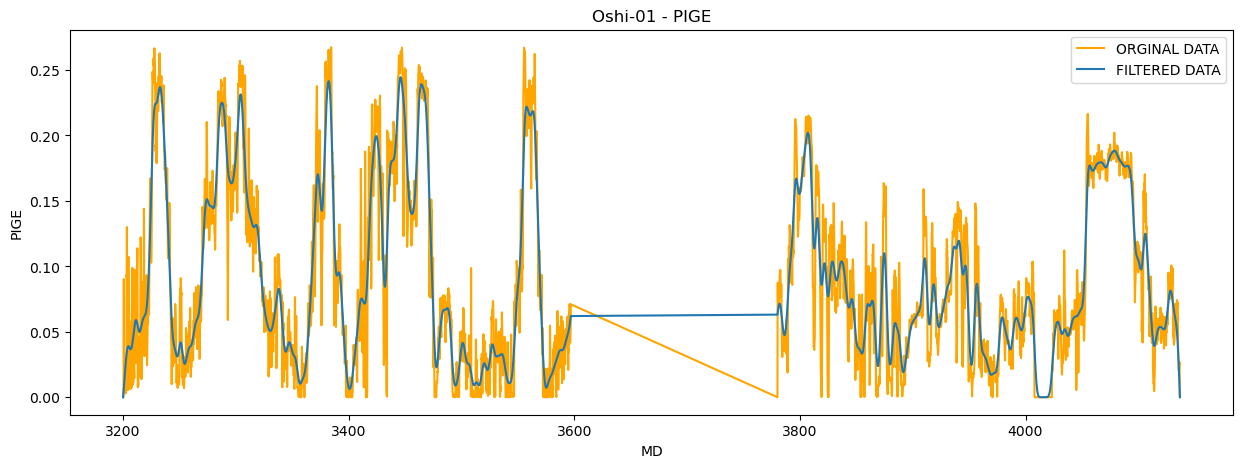

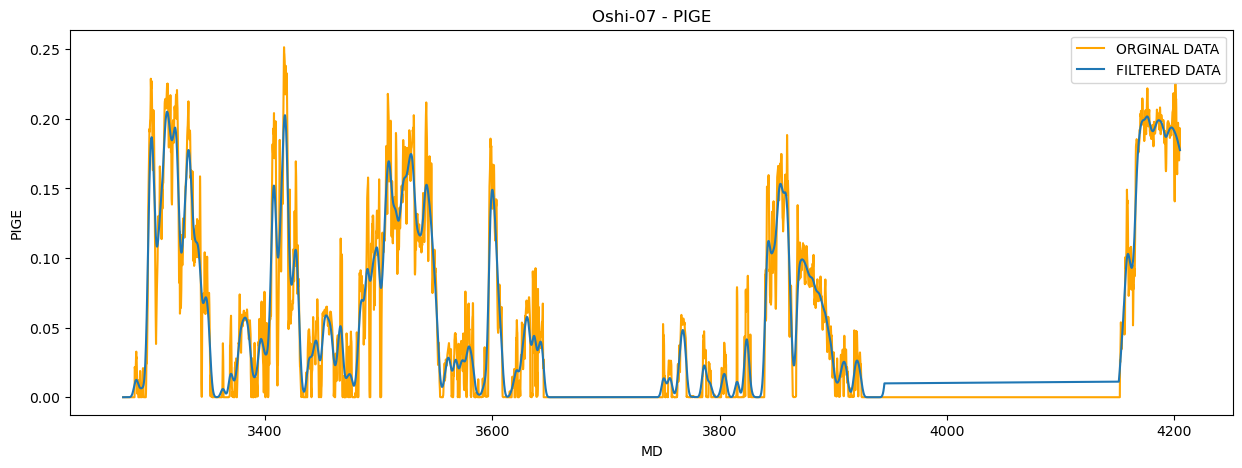

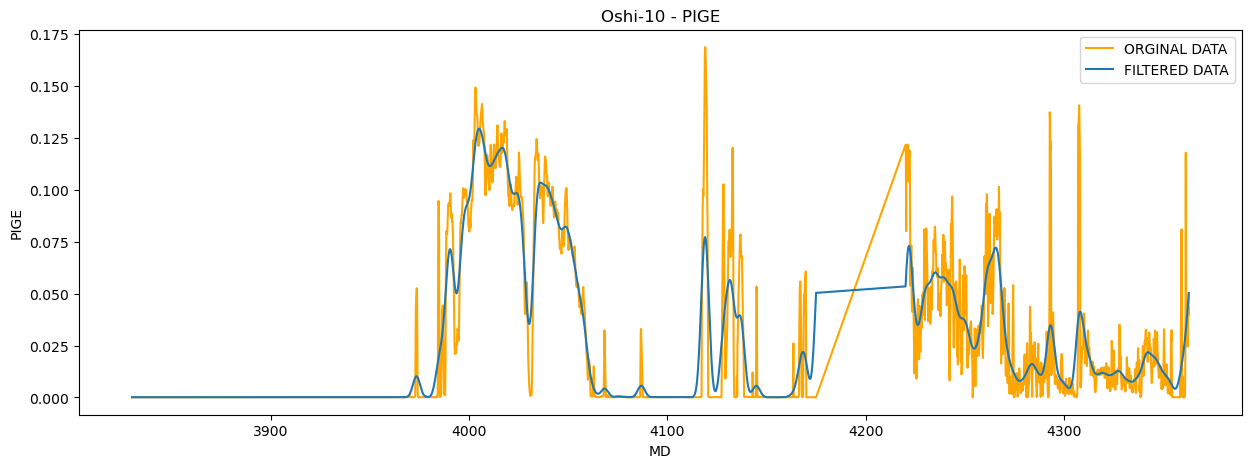

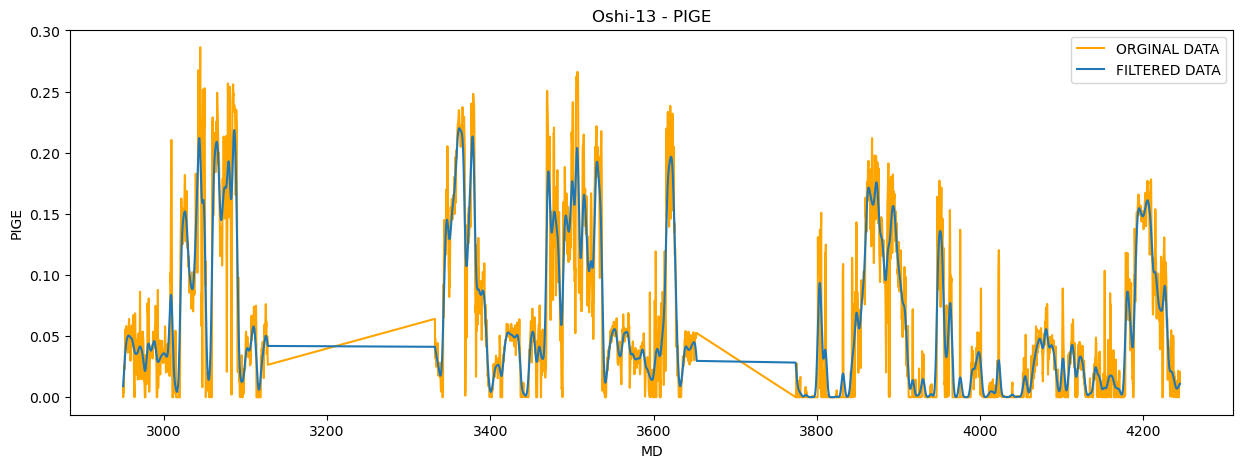

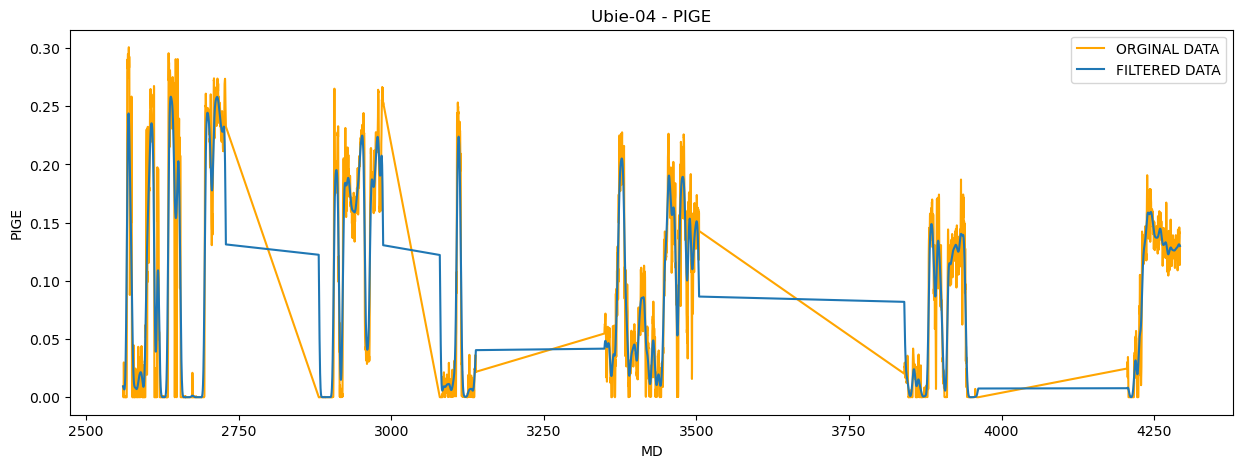

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt
 
def filter_all_wells(wdfs6_SW, n, m):
    filtered_data = pd.DataFrame()
    for well in wdfs6_SW['WELL'].unique():
        dfff = wdfs6_SW[wdfs6_SW['WELL'] == well]
        well_filtered = {'WELL': well, 'MD': dfff['MD'].values}
        for feature in dfff.columns:
            if feature in ['WELL', 'MD']:  # to skip 'WELL' and 'MD'
                continue
            data = dfff[feature].values
            if len(data) < n:
                print(f"Filter order 'n' is greater than the length of the data for well {well} and feature {feature}.")
                continue
            dt = (dfff['MD'].values[1] - dfff['MD'].values[0]).round(4)  
            fNQ = 1 / dt / 2
            if m <= 0 or m >= fNQ:
                print(f"Cutoff frequency 'm' must be between 0 and the Nyquist frequency for well {well} and feature {feature}.")
                continue
            Wn = m / fNQ
            b = firwin(n, Wn)
            filtered_values = filtfilt(b, 1, data)
            well_filtered[feature] = filtered_values
#             well_filtered[feature + '_filtered'] = filtered_values
            
        filt=pd.DataFrame(well_filtered)
        filt=filt.sort_values(by='MD')
#         display(filt)

        for feature in filt.columns:
            if f"{well}_" in feature or feature in ['MD', 'WELL']:
                continue
            plt.figure(figsize=(15, 5))
            plt.plot(dfff['MD'], dfff[feature], color='orange', label='ORGINAL DATA')
            plt.plot(filt['MD'], filt[feature], label="FILTERED DATA")
            plt.xlabel('MD')
            plt.ylabel(feature)
            plt.title(f'{well} - {feature}')
            plt.legend()
            plt.show()
            
        filtered_data = pd.concat([filtered_data, filt], ignore_index=True)
    return filtered_data

n = int(input("Enter Filter Order (n): "))
m = float(input("Enter Cutoff Frequency (m): "))
df_well = filter_all_wells(wdfs6_SW, n, m)
# display(filtered_data)

In [26]:
wdfs6_1=wdfs6[['WELL','MD', 'TWT', 'X', 'Y', 'RMS', 'Env',
       'Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.', 'Sweetness']]

In [27]:
wdfs6.columns

Index(['MD', 'DT', 'GR', 'ILD', 'SN', 'NPHI', 'RHOB', 'SP', 'BS', 'CALI',
       'PHIT', 'PIGE', 'RHGA', 'SUWI', 'VCL', 'EFAC_MERGED', 'WELL', 'TWT',
       'X', 'Y', 'RMS', 'Env', 'Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.',
       'Sweetness'],
      dtype='object')

In [28]:
wdfs6

,MD,DT,GR,ILD,SN,NPHI,RHOB,SP,BS,CALI,...,WELL,TWT,X,Y,RMS,Env,Ins. Freq.,Ins. Ph.,Ref. Inten.,Sweetness
12467,3200.09566,90.112762,74.633667,1.992610,2.594970,NaN,2.35562,64.918121,12.250001,12.783610,...,Oshi-01,2594.73,452359.46498,121283.97612,1949.526123,1547.818359,16.625290,180.000000,6.535233,523.718384
12468,3200.24806,89.717865,84.707932,1.984280,2.592670,NaN,2.35959,65.106255,12.250001,12.827909,...,Oshi-01,2594.82,452359.46498,121283.97612,1949.526123,1547.818359,16.625290,180.000000,6.535233,523.718384
12469,3200.40046,90.844452,86.255829,1.954990,2.387460,NaN,2.38974,65.099411,12.250001,12.822579,...,Oshi-01,2594.91,452359.46498,121283.97612,1949.526123,1547.818359,16.625290,180.000000,6.535233,523.718384
12470,3200.55286,91.713806,101.545723,1.903610,2.546180,0.310670,2.49572,65.279999,12.250001,12.821959,...,Oshi-01,2595.01,452359.46498,121283.97612,1949.526123,1547.818359,16.625290,180.000000,6.535233,523.718384
12471,3200.70526,92.986565,103.000366,1.899600,2.549380,0.316280,2.44669,65.259995,12.250001,12.781030,...,Oshi-01,2595.10,452359.46498,121283.97612,1949.526123,1547.818359,16.625290,180.000000,6.535233,523.718384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107639,4291.73640,74.834305,26.403032,23.709900,17.962099,0.061093,2.38550,90.414398,8.500000,7.851100,...,Ubie-04,3238.25,457656.52173,121741.71635,1762.268799,1559.915039,24.889368,48.585869,4.700782,312.675629
107640,4291.88880,74.308098,26.403032,22.045900,17.129499,0.061093,2.41710,90.300095,8.500000,7.812900,...,Ubie-04,3238.33,457656.52173,121741.71635,1762.268799,1559.915039,24.889368,48.585869,4.700782,312.675629
107641,4292.04120,73.687599,26.403032,20.301901,16.052000,0.057749,2.44480,90.082100,8.500000,7.800400,...,Ubie-04,3238.41,457656.52173,121741.71635,1762.268799,1559.915039,24.889368,48.585869,4.700782,312.675629
107642,4292.19360,73.342499,26.403032,19.537600,15.258700,0.070412,2.44270,89.759995,8.500000,7.798800,...,Ubie-04,3238.48,457656.52173,121741.71635,1762.268799,1559.915039,24.889368,48.585869,4.700782,312.675629


In [29]:
# Set both WELL and MD as index for both dataframes to align them
df_well_set = df_well.set_index(['WELL', 'MD'])
wdfs6_set = wdfs6_1.set_index(['WELL', 'MD'])

# Concatenate along columns (axis=1) based on WELL and MD indices
concatenated_df = pd.concat([df_well_set, wdfs6_set], axis=1, join='inner').reset_index()

In [30]:
# Set both WELL and MD as index for both dataframes to align them
df_well_set = df_well.set_index(['WELL', 'MD'])
wdfs6_set = wdfs6_1.set_index(['WELL', 'MD'])

# Concatenate along columns (axis=1) based on WELL and MD indices
concatenated_df = pd.concat([df_well_set, wdfs6_set], axis=1, join='inner').reset_index()


In [31]:
wdfs6_set

TWT             X             Y          RMS  \
WELL    MD                                                             
Oshi-01 3200.09566  2594.73  452359.46498  121283.97612  1949.526123   
        3200.24806  2594.82  452359.46498  121283.97612  1949.526123   
        3200.40046  2594.91  452359.46498  121283.97612  1949.526123   
        3200.55286  2595.01  452359.46498  121283.97612  1949.526123   
        3200.70526  2595.10  452359.46498  121283.97612  1949.526123   
...                     ...           ...           ...          ...   
Ubie-04 4291.73640  3238.25  457656.52173  121741.71635  1762.268799   
        4291.88880  3238.33  457656.52173  121741.71635  1762.268799   
        4292.04120  3238.41  457656.52173  121741.71635  1762.268799   
        4292.19360  3238.48  457656.52173  121741.71635  1762.268799   
        4292.34600  3238.56  457656.52173  121741.71635  1762.268799   

                            Env  Ins. Freq.    Ins. Ph.  Ref. Inten.  \
WELL    MD                                                             
Oshi-01 3200.09566  1547.818359   16.625290  180.000000     6.535233   
        3200.24806  1547.818359   16.625290  180.000000     6.535233   
        3200.40046  1547.818359   16.625290  180.000000     6.535233   
        3200.55286  1547.818359   16.625290  180.000000     6.535233   
        3200.70526  1547.818359   16.625290  180.000000     6.535233   
...                         ...         ...         ...          ...   
Ubie-04 4291.73640  1559.915039   24.889368   48.585869     4.700782   
        4291.88880  1559.915039   24.889368   48.585869     4.700782   
        4292.04120  1559.915039   24.889368   48.585869     4.700782   
        4292.19360  1559.915039   24.889368   48.585869     4.700782   
        4292.34600  1559.915039   24.889368   48.585869     4.700782   

                     Sweetness  
WELL    MD                      
Oshi-01 3200.09566  523.718384  
        3200.24806  523.718384  
        3200.40046  523.718384  
        3200.55286  523.718384  
        3200.70526  523.718384  
...                        ...  
Ubie-04 4291.73640  312.675629  
        4291.88880  312.675629  
        4292.04120  312.675629  
        4292.19360  312.675629  
        4292.34600  312.675629  

[23831 rows x 9 columns]

In [32]:
wdfs6_set.isna().sum()

TWT            0
X              0
Y              0
RMS            0
Env            0
Ins. Freq.     0
Ins. Ph.       0
Ref. Inten.    0
Sweetness      0
dtype: int64

Manual adjustment of depth ranges applied to constrain the depth analysis window across all available wells.

LEVEL 71 ONLY OSHI01,OSHI07, OSHI10, OSHI13

In [33]:
# Step 2: Apply depth constraints for each well (with TWT ranges)
def constrain_depth(row):
    if row['WELL'] == 'Oshi-01':
        # Set the TWT range for 'Oshi-01'
        return 3105 <= row['TWT'] <= 3134
    elif row['WELL'] == 'Oshi-07':
        # Set the TWT range for 'Oshi-07'
        return 3180 <= row['TWT'] <= 3208
    elif row['WELL'] == 'Oshi-10':
        # Set the TWT range for 'Oshi-10'
        return 3282 <= row['TWT'] <= 3299
    elif row['WELL'] == 'Oshi-13':
        # Set the TWT range for 'Oshi-13'
        return 3196 <= row['TWT'] <= 3215
    elif row['WELL'] == 'Ubie-04':
        return 3213 <= row['TWT'] <= 3238
    return True  # Default case, should not be reached if the well is valid, should not be reached if the well is valid

 # Apply the depth constraints to filter the dataframe
df_c = concatenated_df[concatenated_df.apply(constrain_depth, axis=1)]

In [34]:
df_c.columns

Index(['WELL', 'MD', 'PIGE', 'TWT', 'X', 'Y', 'RMS', 'Env', 'Ins. Freq.',
       'Ins. Ph.', 'Ref. Inten.', 'Sweetness'],
      dtype='object')

In [35]:
columns=df_c[[ 'PIGE', 'RMS', 'Env','Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.', 'Sweetness']]

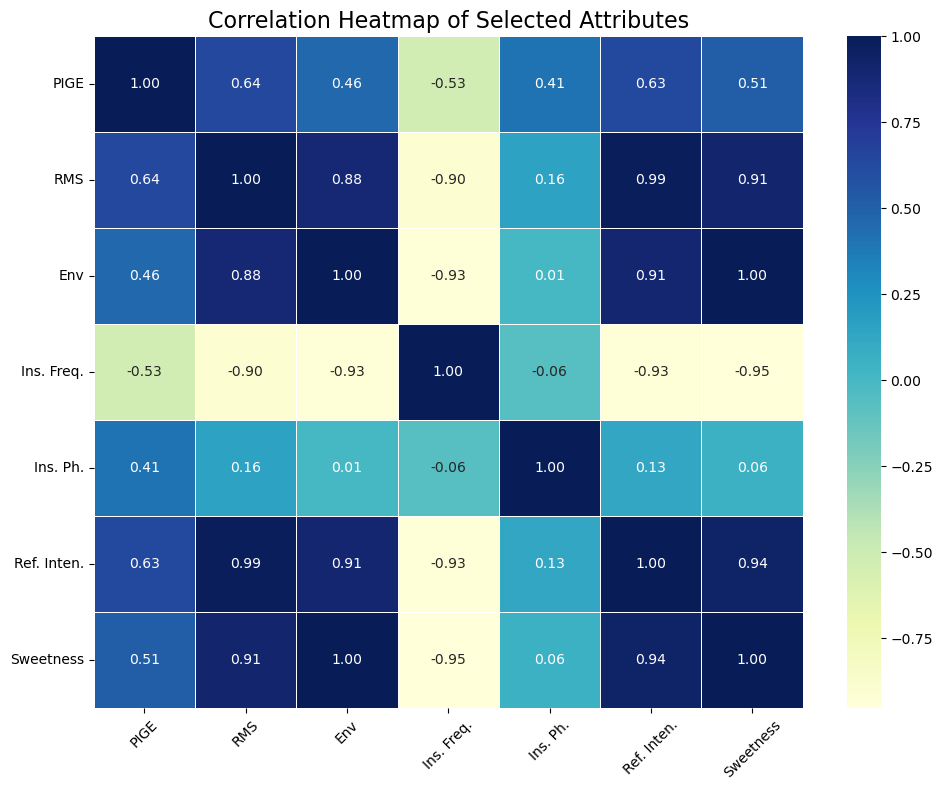

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns to analyze
columns = ['PIGE', 'RMS', 'Env','Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.', 'Sweetness']

# Filter the DataFrame
df_corr = df_c[columns]

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap of Selected Attributes', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
df_c.columns

Index(['WELL', 'MD', 'PIGE', 'TWT', 'X', 'Y', 'RMS', 'Env', 'Ins. Freq.',
       'Ins. Ph.', 'Ref. Inten.', 'Sweetness'],
      dtype='object')

Features with correlation higher than 0.60 or lower than -0.60 with PIGE:
Ref. Inten._square: 0.6623
RMS_square: 0.6623
RMS_original: 0.6386
Ref. Inten._original: 0.6313
RMS_sqrt: 0.6232
Ref. Inten._log_square: 0.6127
RMS_log_square: 0.6105
Ref. Inten._sqrt: 0.6103
RMS_log: 0.6058
RMS_sqrt_log: 0.6033


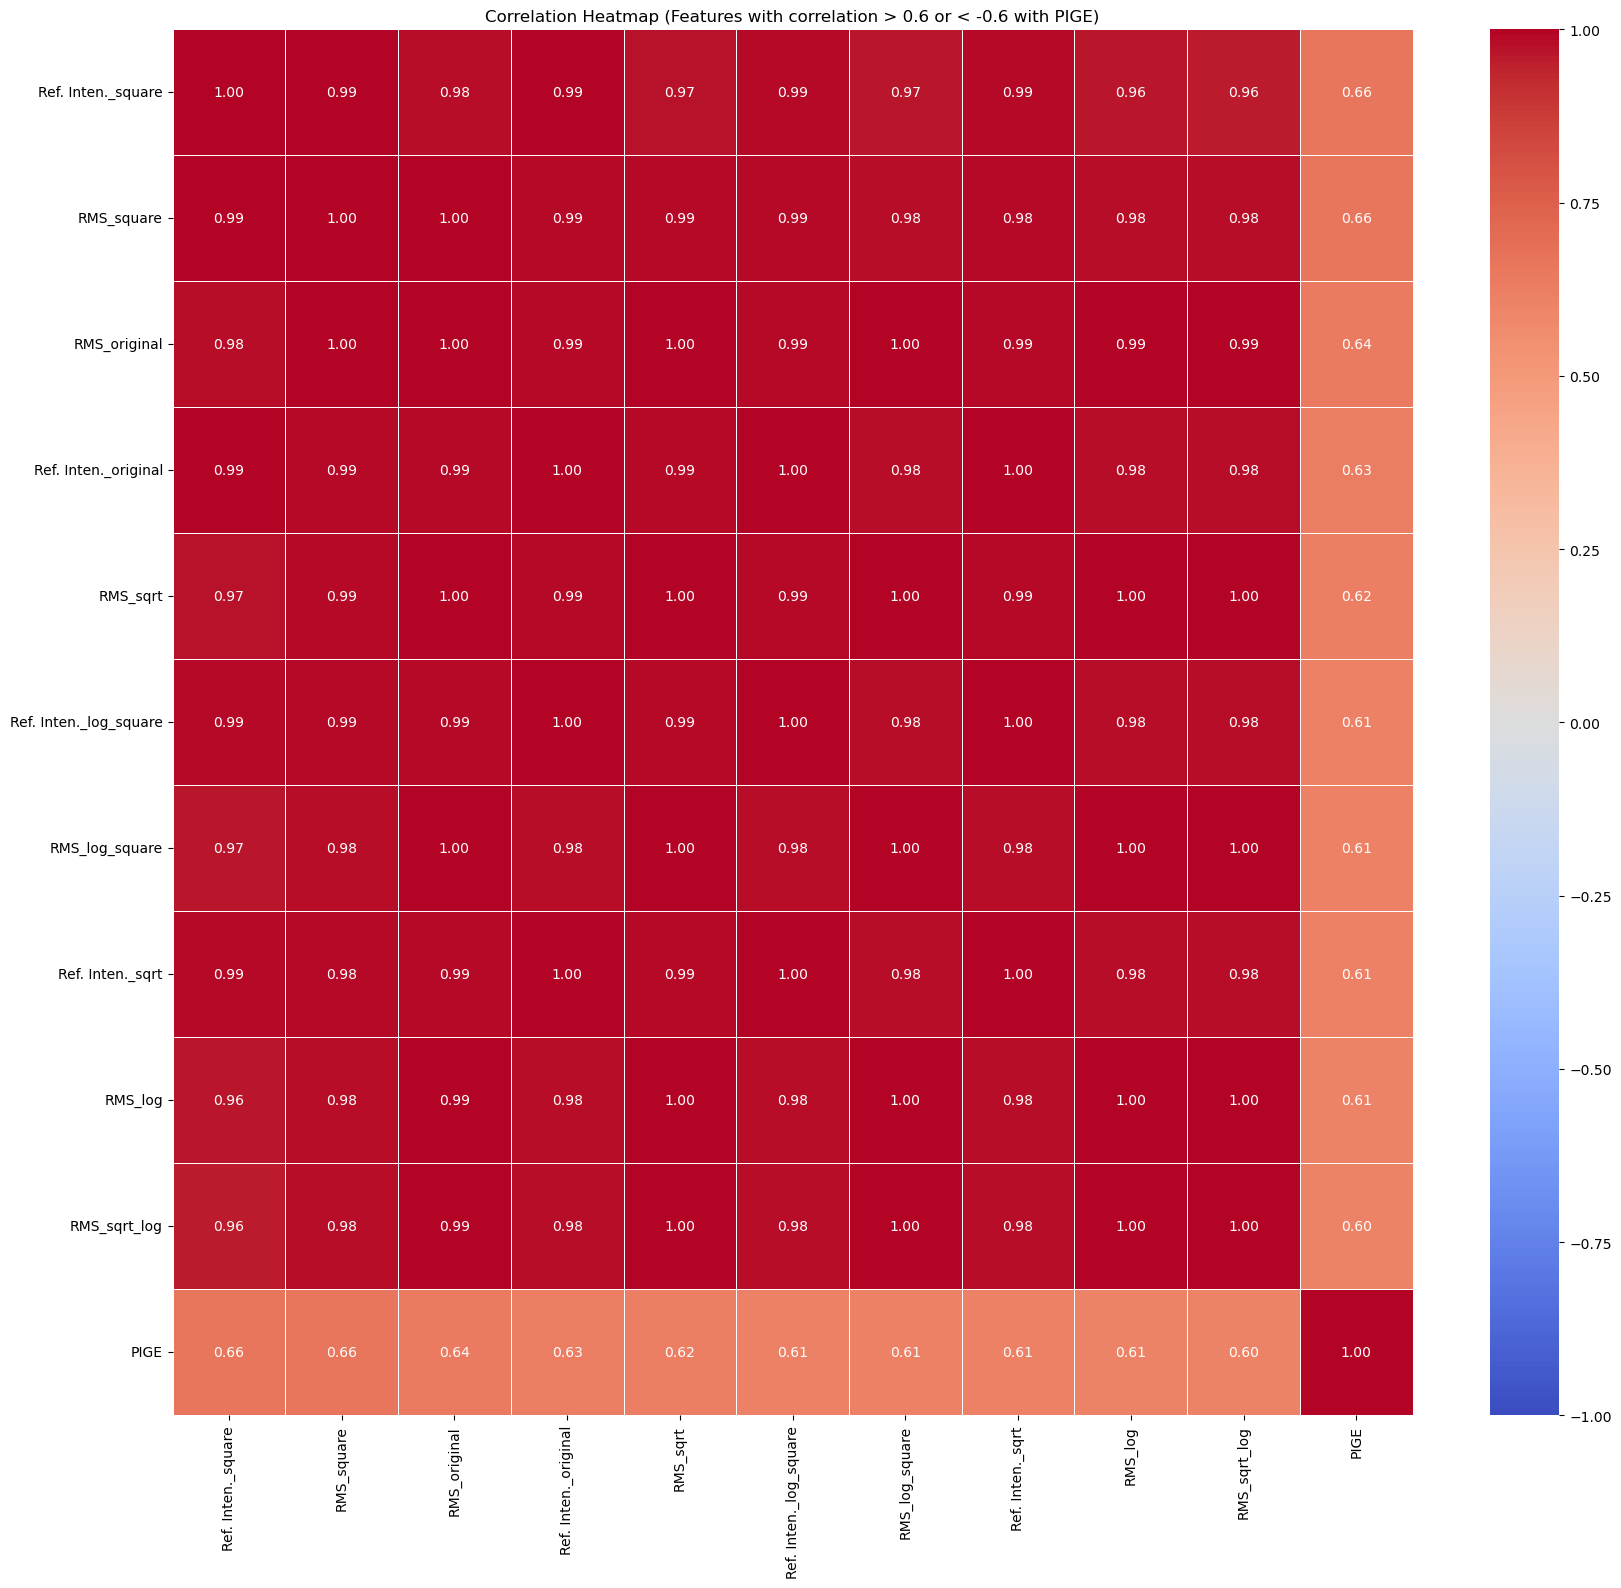

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Function to apply transformations to each feature
def apply_transformations(df, features):
    transformed_data = {}
    
    for feature in features:
        # Skip if the feature has missing values
        if df[feature].isnull().any():
            continue

        # Original feature
        transformed_data[f'{feature}_original'] = df[feature]
        
        # Square root transformation
        transformed_data[f'{feature}_sqrt'] = np.sqrt(df[feature].clip(lower=0))  # Avoid sqrt of negative values
        
        # Logarithmic transformation (add a small value to avoid log(0) or negative values)
        transformed_data[f'{feature}_log'] = np.log(df[feature].clip(lower=1e-5))
        
        # Inverse transformation
        transformed_data[f'{feature}_inverse'] = 1 / (df[feature].replace(0, np.nan))  # Avoid division by zero
        
        # Inverse square transformation
        transformed_data[f'{feature}_inv_sq'] = 1 / (df[feature] ** 2).replace(0, np.nan)  # Avoid division by zero
        
        # Square transformation
        transformed_data[f'{feature}_square'] = df[feature] ** 2
        
        # Square of logarithmic transformation
        transformed_data[f'{feature}_log_square'] = (np.log(df[feature].clip(lower=1e-5))) ** 2
        
        # Square root of logarithmic transformation
        transformed_data[f'{feature}_sqrt_log'] = np.sqrt(np.log(df[feature].clip(lower=1e-5)))
        
    return pd.DataFrame(transformed_data)

# Function to calculate the correlation with PHIE for each feature and its transformations
def correlation_with_target(df, target_feature):
    correlations = {}
    
    # Ensure the target feature 'PGIE' is present
    if target_feature not in df.columns:
        raise ValueError(f"The target feature '{target_feature}' is not present in the dataframe.")
    
    # Drop rows with NaN or infinite values in the DataFrame
    df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[target_feature])
    
    for column in df_clean.columns:
        if column != target_feature:
            # Calculate Pearson correlation
            try:
                corr, _ = pearsonr(df_clean[column], df_clean[target_feature])
                correlations[column] = corr
            except ValueError:
                # Handle case where Pearson correlation cannot be computed (e.g., constant columns)
                correlations[column] = np.nan
    
    # Sort the correlations by their absolute value to find the maximum correlation
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    return sorted_correlations

# Assuming you have your dataset in a pandas DataFrame called df_c
# Example list of features (update with the actual column names from df_c)
features = ['RMS', 'Env',
       'Ins. Freq.', 'Ins. Ph.', 'Ref. Inten.', 'Sweetness']

# Apply transformations (including PHIE)
transformed_df = apply_transformations(df_c, features)

# Ensure PHIE is in the DataFrame (assuming PHIE is available in df_c)
transformed_df['PIGE'] = df_c['PIGE']

# Target feature (PHIE)
target_feature = 'PIGE'

# Calculate correlation with PIGE
correlation_results = correlation_with_target(transformed_df, target_feature)

# Filter results to show only correlations greater than +/- 0.7
filtered_results = [(feature, correlation) for feature, correlation in correlation_results if abs(correlation) >= 0.60]

# Display results
print("Features with correlation higher than 0.60 or lower than -0.60 with PIGE:")
for feature, correlation in filtered_results:
    print(f"{feature}: {correlation:.4f}")

# Create a new DataFrame for features with correlation >= 0.6 or <= -0.6
high_corr_features = [feature for feature, _ in filtered_results]

# Extract only the relevant columns from the transformed DataFrame
high_corr_df = transformed_df[high_corr_features + [target_feature]]

# Create a correlation matrix for these features
correlation_matrix = high_corr_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title(f"Correlation Heatmap (Features with correlation > 0.6 or < -0.6 with {target_feature})")
plt.show()

In [39]:
high_corr_df=high_corr_df.reset_index()

In [40]:
df_select=df_c[['WELL', 'MD', 'TWT', 'X', 'Y']]

In [41]:
df_select=df_select.reset_index()

In [42]:
import pandas as pd

# Assuming you have two dataframes: df_select and high_corr_df
merged_df = pd.merge(df_select, high_corr_df, on='index', how='left')  # Replace 'your_common_column' with the actual column name


In [43]:
merged_df.columns

Index(['index', 'WELL', 'MD', 'TWT', 'X', 'Y', 'Ref. Inten._square',
       'RMS_square', 'RMS_original', 'Ref. Inten._original', 'RMS_sqrt',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt',
       'RMS_log', 'RMS_sqrt_log', 'PIGE'],
      dtype='object')

In [44]:
features_cm=merged_df[['RMS_square', 'RMS_original',
       'RMS_sqrt', 'Ref. Inten._square', 'Ref. Inten._original',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt', 'PIGE']]

Training data preparation

In [45]:
df_cm=merged_df.copy()

In [46]:
features_cm=df_cm[['RMS_square', 'RMS_original',
       'RMS_sqrt', 'Ref. Inten._square', 'Ref. Inten._original',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt', 'PIGE']]

In [47]:
# Training Wells
training_wells = ['Oshi-07', 'Oshi-13', 'Oshi-10','Ubie-04']

# Test Well
test_well = ['Oshi-01']

In [48]:
traindf = df_cm[df_cm['WELL'].isin(training_wells)].copy()
testdf = df_cm[df_cm['WELL'].isin(test_well)].copy()

In [49]:
# Assuming df_cm is already loaded and the features_cm dataframe has been created
features_cmtr = traindf[['RMS_square', 'RMS_original',
       'RMS_sqrt', 'Ref. Inten._square', 'Ref. Inten._original',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt', 'PIGE']]

# # Plotting histogram for the selected features
# features_cm.hist(bins=20, figsize=(10, 8))

# # Show the plot
# plt.tight_layout()
# plt.show()

In [50]:
# Assuming df_cm is already loaded and the features_cm dataframe has been created
features_cmt = testdf[['RMS_square', 'RMS_original',
       'RMS_sqrt', 'Ref. Inten._square', 'Ref. Inten._original',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt', 'PIGE']]

# # Plotting histogram for the selected features
# features_cm.hist(bins=20, figsize=(10, 8))

# # Show the plot
# plt.tight_layout()
# plt.show()

In [51]:
# Step 1: Apply Min-Max Scaler to features
scaler = MinMaxScaler()

# Columns to scale
columns_to_scale = ['RMS_square', 'RMS_original',
       'RMS_sqrt', 'Ref. Inten._square', 'Ref. Inten._original',
       'Ref. Inten._log_square', 'RMS_log_square', 'Ref. Inten._sqrt']

# Fit and transform the training features
features_cmtr[columns_to_scale] = scaler.fit_transform(features_cmtr[columns_to_scale])

# Transform the test features
features_cmt[columns_to_scale] = scaler.transform(features_cmt[columns_to_scale])

# Step 2: Scale the target variable PHIE
target_scaler = MinMaxScaler()

# Fit the target scaler on the training target data
y_train_scaled = target_scaler.fit_transform(features_cmtr[['PIGE']])

# Transform the test target data
y_test_scaled = target_scaler.transform(features_cmt[['PIGE']])

# Step 3: Prepare training data (X_train) and target (y_train) for ANN
X_train = features_cmtr[columns_to_scale]
y_train = y_train_scaled  # Scaled PHIE for training

# Prepare test data (X_test) and target (y_test) for ANN
X_test = features_cmt[columns_to_scale]
y_test = y_test_scaled  # Scaled PHIE for testing

# Step 4: Build the ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # n_features = X_train.shape[1]
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 5: Train the model
epochs = 100
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=1)
# Step 6: Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {test_mae}")

# Step 7: Calculate training R² score
y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

train_r2 = r2_score(y_train_original, y_train_pred)
print(f"Training R² Score: {train_r2}")

# Step 8: Make predictions
y_pred_scaled = model.predict(X_test)

# Step 9: Inverse transform the scaled predictions to original PHIE values
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Step 10: Inverse transform the scaled actual test PHIE values to original scale
y_test_original = target_scaler.inverse_transform(y_test)

# Step 11: Calculate additional metrics (optional)
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)  # R² score

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Optional: Compare the predicted vs actual values
predicted_vs_actual = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': y_pred.flatten()})
print(predicted_vs_actual.head())


Epoch 1/100
17/17 [==============================] - 1s 17ms/step - loss: 0.3341 - mae: 0.5216 - val_loss: 1.2982 - val_mae: 1.1278
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1264 - mae: 0.3035 - val_loss: 0.0111 - val_mae: 0.0801
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0527 - mae: 0.1612 - val_loss: 0.1903 - val_mae: 0.4263
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0445 - mae: 0.1468 - val_loss: 0.1421 - val_mae: 0.3665
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0472 - mae: 0.1426 - val_loss: 0.0980 - val_mae: 0.3014
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0452 - mae: 0.1431 - val_loss: 0.1689 - val_mae: 0.4010
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0451 - mae: 0.1501 - val_loss: 0.1352 - val_mae: 0.3571
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0456 - 

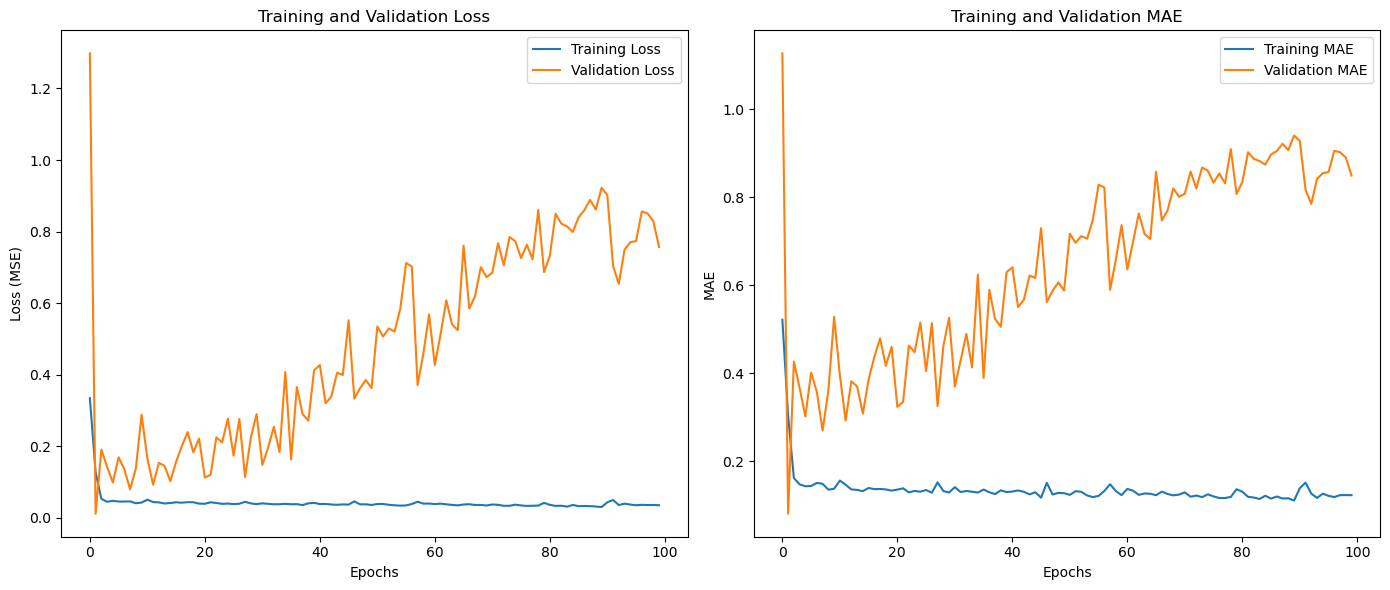

In [52]:
# Step 12: Plot the training and validation loss over epochs
plt.figure(figsize=(14, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot for MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

The final trained deep learning model is implemented on a blind well (not used during training) to validate and visualize the predicted reservoir properties.

This step provides a critical assessment of the model’s predictive strength beyond well control within the selected reservoir formation.

In [53]:
df_p_a=predicted_vs_actual.copy()

In [54]:
df_test=testdf.reset_index()

In [55]:
df_p_a['TWT'] = df_test['TWT']

In [56]:
df_p_a['TWT'] = df_test['TWT']

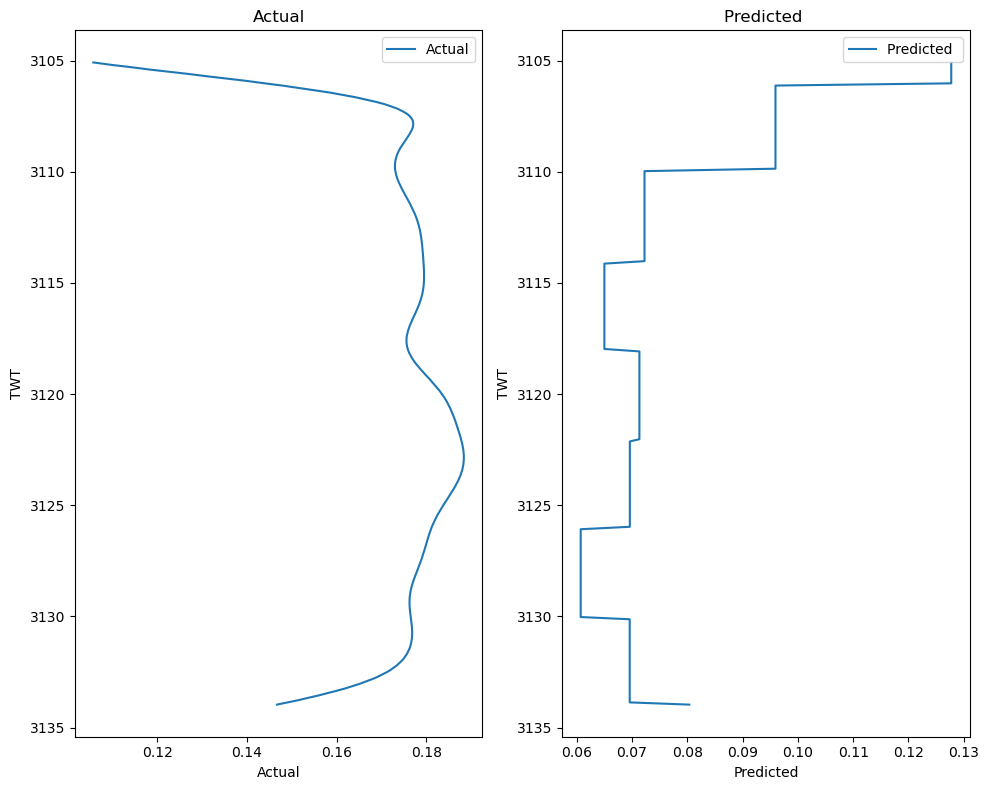

In [57]:
import matplotlib.pyplot as plt

# Create a figure with a 1x2 grid (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 8))  # Adjust figsize as needed

# Plot 1: Actual vs TWT
axs[0].plot(df_p_a['Actual'], df_p_a['TWT'], label='Actual')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('TWT')
axs[0].set_title('Actual')
axs[0].legend()
axs[0].invert_yaxis()

# Plot 2: Predicted vs TWT
axs[1].plot(df_p_a['Predicted'], df_p_a['TWT'], label='Predicted ')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('TWT')
axs[1].set_title('Predicted ')
axs[1].legend()
axs[1].invert_yaxis()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()